# Waler2DBulletEnv with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pybullet_envs
import pybullet_envs.bullet as bul

import torch.nn.functional as F

import gym
import os

import time
from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from collections import deque
import itertools as it


current_dir=D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\pybullet_envs\bullet
device:  cuda


In [2]:
start_timestep=1e4

std_noise=0.02

env = gym.make('Walker2DBulletEnv-v0')

# Set seeds
seed = 12345
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('start_dim: ', state_dim, ', action_dim: ', action_dim)
print('max_action: ', max_action, ', threshold: ', threshold, ', std_noise: ', std_noise)

agent = TD3(state_dim, action_dim, max_action)


start_dim:  22 , action_dim:  6
max_action:  1.0 , threshold:  2500.0 , std_noise:  0.02


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=15000, save_every=10, print_env=10):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        max_score = np.max(scores_deque)

        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        if i_episode % print_env == 0 or (len(scores_deque) == 100 and avg_score > threshold):
            print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Max.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, max_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every and i_episode > 0:

            timestep_after_last_save %= save_every            
            save(agent, 'chpnt_interm', 'dir_Walker2D_002')  
        
        if len(scores_deque) == 100 and avg_score >= threshold:
            print('Environment solved with Average Score: ',  avg_score )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train()

Low in action space:  [-1. -1. -1. -1. -1. -1.] , High:  [1. 1. 1. 1. 1. 1.] , Action_dim:  6
Ep. 10, Timestep 130,  Ep.Timesteps 9, Score: 15.12, Avg.Score: 15.75, Max.Score: 22.04, Time: 00:00:10 
Ep. 20, Timestep 267,  Ep.Timesteps 21, Score: 20.10, Avg.Score: 16.19, Max.Score: 23.60, Time: 00:00:14 
Ep. 30, Timestep 400,  Ep.Timesteps 7, Score: 11.34, Avg.Score: 16.01, Max.Score: 23.60, Time: 00:00:20 
Ep. 40, Timestep 532,  Ep.Timesteps 14, Score: 16.95, Avg.Score: 16.11, Max.Score: 23.60, Time: 00:00:24 
Ep. 50, Timestep 686,  Ep.Timesteps 12, Score: 16.28, Avg.Score: 16.43, Max.Score: 27.63, Time: 00:00:29 
Ep. 60, Timestep 828,  Ep.Timesteps 10, Score: 15.38, Avg.Score: 16.57, Max.Score: 27.63, Time: 00:00:34 
Ep. 70, Timestep 978,  Ep.Timesteps 17, Score: 17.69, Avg.Score: 16.66, Max.Score: 28.73, Time: 00:00:40 
Ep. 80, Timestep 1125,  Ep.Timesteps 28, Score: 28.02, Avg.Score: 16.72, Max.Score: 28.73, Time: 00:00:45 
Ep. 90, Timestep 1273,  Ep.Timesteps 11, Score: 13.91, Avg.

Ep. 1480, Timestep 145517,  Ep.Timesteps 1000, Score: 1389.54, Avg.Score: 291.56, Max.Score: 1389.54, Time: 01:29:46 
Ep. 1490, Timestep 151494,  Ep.Timesteps 585, Score: 720.36, Avg.Score: 324.66, Max.Score: 1389.54, Time: 01:33:26 
Ep. 1500, Timestep 157246,  Ep.Timesteps 1000, Score: 829.30, Avg.Score: 369.39, Max.Score: 1389.54, Time: 01:36:31 
Ep. 1510, Timestep 160266,  Ep.Timesteps 193, Score: 235.93, Avg.Score: 388.90, Max.Score: 1389.54, Time: 01:38:42 
Ep. 1520, Timestep 165260,  Ep.Timesteps 801, Score: 760.39, Avg.Score: 424.22, Max.Score: 1389.54, Time: 01:41:14 
Ep. 1530, Timestep 173172,  Ep.Timesteps 1000, Score: 1232.69, Avg.Score: 509.70, Max.Score: 1389.54, Time: 01:45:39 
Ep. 1540, Timestep 181945,  Ep.Timesteps 1000, Score: 829.50, Avg.Score: 609.87, Max.Score: 1389.54, Time: 01:50:41 
Ep. 1550, Timestep 189716,  Ep.Timesteps 1000, Score: 1196.66, Avg.Score: 664.49, Max.Score: 1418.66, Time: 01:55:08 
Ep. 1560, Timestep 196200,  Ep.Timesteps 123, Score: 144.87, Avg

Ep. 2860, Timestep 1230659,  Ep.Timesteps 345, Score: 608.42, Avg.Score: 1279.63, Max.Score: 1925.59, Time: 12:04:44 
Ep. 2870, Timestep 1240215,  Ep.Timesteps 1000, Score: 1848.46, Avg.Score: 1447.95, Max.Score: 1970.49, Time: 12:09:52 
Ep. 2880, Timestep 1246892,  Ep.Timesteps 581, Score: 1045.23, Avg.Score: 1432.06, Max.Score: 1970.49, Time: 12:13:54 
Ep. 2890, Timestep 1256371,  Ep.Timesteps 1000, Score: 1779.85, Avg.Score: 1546.06, Max.Score: 1970.49, Time: 12:19:05 
Ep. 2900, Timestep 1266371,  Ep.Timesteps 1000, Score: 1659.49, Avg.Score: 1629.76, Max.Score: 1970.49, Time: 12:24:56 
Ep. 2910, Timestep 1275393,  Ep.Timesteps 1000, Score: 1806.20, Avg.Score: 1642.06, Max.Score: 1970.49, Time: 12:30:04 
Ep. 2920, Timestep 1284517,  Ep.Timesteps 1000, Score: 1728.41, Avg.Score: 1635.41, Max.Score: 1970.49, Time: 12:35:21 
Ep. 2930, Timestep 1292752,  Ep.Timesteps 1000, Score: 1788.37, Avg.Score: 1608.88, Max.Score: 1970.49, Time: 12:40:03 
Ep. 2940, Timestep 1300355,  Ep.Timesteps 1

Ep. 4220, Timestep 2366217,  Ep.Timesteps 1000, Score: 2083.86, Avg.Score: 1644.19, Max.Score: 2203.03, Time: 23:37:52 
Ep. 4230, Timestep 2375281,  Ep.Timesteps 1000, Score: 2068.88, Avg.Score: 1692.35, Max.Score: 2203.03, Time: 23:43:37 
Ep. 4240, Timestep 2385281,  Ep.Timesteps 1000, Score: 2016.66, Avg.Score: 1785.44, Max.Score: 2203.03, Time: 23:49:48 
Ep. 4250, Timestep 2395281,  Ep.Timesteps 1000, Score: 2064.15, Avg.Score: 1822.12, Max.Score: 2203.03, Time: 23:55:50 
Ep. 4260, Timestep 2404464,  Ep.Timesteps 1000, Score: 2141.68, Avg.Score: 1798.81, Max.Score: 2203.03, Time: 24:01:11 
Ep. 4270, Timestep 2414224,  Ep.Timesteps 1000, Score: 2063.64, Avg.Score: 1812.46, Max.Score: 2203.03, Time: 24:06:51 
Ep. 4280, Timestep 2424224,  Ep.Timesteps 1000, Score: 2158.47, Avg.Score: 1865.77, Max.Score: 2203.03, Time: 24:12:52 
Ep. 4290, Timestep 2432914,  Ep.Timesteps 1000, Score: 2097.12, Avg.Score: 1943.38, Max.Score: 2203.03, Time: 24:17:54 
Ep. 4300, Timestep 2442914,  Ep.Timestep

Ep. 5580, Timestep 3471883,  Ep.Timesteps 1000, Score: 2086.63, Avg.Score: 1195.04, Max.Score: 2238.71, Time: 34:48:20 
Ep. 5590, Timestep 3481883,  Ep.Timesteps 1000, Score: 2058.47, Avg.Score: 1385.03, Max.Score: 2238.71, Time: 34:54:02 
Ep. 5600, Timestep 3491169,  Ep.Timesteps 286, Score: 571.69, Avg.Score: 1571.59, Max.Score: 2238.71, Time: 34:59:39 
Ep. 5610, Timestep 3500209,  Ep.Timesteps 1000, Score: 2117.53, Avg.Score: 1745.83, Max.Score: 2256.70, Time: 35:04:23 
Ep. 5620, Timestep 3509671,  Ep.Timesteps 1000, Score: 2150.30, Avg.Score: 1899.26, Max.Score: 2269.35, Time: 35:09:46 
Ep. 5630, Timestep 3519174,  Ep.Timesteps 1000, Score: 2167.54, Avg.Score: 1915.57, Max.Score: 2269.35, Time: 35:15:07 
Ep. 5640, Timestep 3529174,  Ep.Timesteps 1000, Score: 2150.40, Avg.Score: 1996.39, Max.Score: 2269.35, Time: 35:20:48 
Ep. 5650, Timestep 3536442,  Ep.Timesteps 118, Score: 208.21, Avg.Score: 1969.31, Max.Score: 2269.35, Time: 35:25:23 
Ep. 5660, Timestep 3545073,  Ep.Timesteps 10

Ep. 6980, Timestep 4182420,  Ep.Timesteps 1000, Score: 2302.95, Avg.Score: 2183.81, Max.Score: 2346.66, Time: 41:37:55 
Ep. 6990, Timestep 4192420,  Ep.Timesteps 1000, Score: 2257.60, Avg.Score: 2192.24, Max.Score: 2346.66, Time: 41:43:45 
Ep. 7000, Timestep 4201332,  Ep.Timesteps 1000, Score: 2263.31, Avg.Score: 2180.31, Max.Score: 2346.66, Time: 41:48:58 
Ep. 7010, Timestep 4211332,  Ep.Timesteps 1000, Score: 2325.45, Avg.Score: 2182.71, Max.Score: 2346.66, Time: 41:54:56 
Ep. 7020, Timestep 4220040,  Ep.Timesteps 1000, Score: 2324.21, Avg.Score: 2174.46, Max.Score: 2346.66, Time: 42:00:28 
Ep. 7030, Timestep 4230040,  Ep.Timesteps 1000, Score: 2392.00, Avg.Score: 2179.65, Max.Score: 2392.00, Time: 42:06:52 
Ep. 7040, Timestep 4239258,  Ep.Timesteps 1000, Score: 2100.26, Avg.Score: 2159.88, Max.Score: 2392.00, Time: 42:12:51 
Ep. 7050, Timestep 4248977,  Ep.Timesteps 1000, Score: 2230.06, Avg.Score: 2145.60, Max.Score: 2392.00, Time: 42:19:07 
Ep. 7060, Timestep 4253534,  Ep.Timestep

Ep. 8350, Timestep 5182517,  Ep.Timesteps 742, Score: 1765.31, Avg.Score: 2280.53, Max.Score: 2543.94, Time: 50:23:04 
Ep. 8360, Timestep 5191043,  Ep.Timesteps 1000, Score: 2468.54, Avg.Score: 2273.74, Max.Score: 2543.94, Time: 50:26:17 
Ep. 8370, Timestep 5201043,  Ep.Timesteps 1000, Score: 2435.98, Avg.Score: 2288.12, Max.Score: 2543.94, Time: 50:30:09 
Ep. 8380, Timestep 5211043,  Ep.Timesteps 1000, Score: 2171.20, Avg.Score: 2276.12, Max.Score: 2543.94, Time: 50:34:01 
Ep. 8390, Timestep 5221043,  Ep.Timesteps 1000, Score: 2247.60, Avg.Score: 2260.01, Max.Score: 2510.92, Time: 50:37:55 
Ep. 8400, Timestep 5225764,  Ep.Timesteps 1000, Score: 1982.53, Avg.Score: 2122.80, Max.Score: 2510.92, Time: 50:39:44 
Ep. 8410, Timestep 5227427,  Ep.Timesteps 157, Score: 227.38, Avg.Score: 1907.44, Max.Score: 2510.92, Time: 50:40:41 
Ep. 8420, Timestep 5234772,  Ep.Timesteps 1000, Score: 1728.00, Avg.Score: 1800.77, Max.Score: 2510.92, Time: 50:43:13 
Ep. 8430, Timestep 5243924,  Ep.Timesteps 1

In [5]:
save(agent, 'chpnt_ts2500', 'dir_Walker2D_002')  

length of scores:  9361 , len of avg_scores:  9361


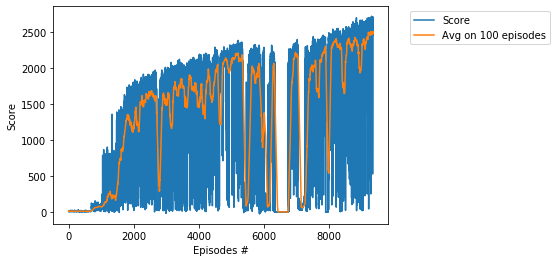

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [7]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            time.sleep(0.01)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=7)


Episode 1	Average Score: 2537.76,	Score: 2537.76 	Time: 00:00:14
Episode 2	Average Score: 2537.58,	Score: 2537.40 	Time: 00:00:13
Episode 3	Average Score: 2536.35,	Score: 2533.88 	Time: 00:00:13
Episode 4	Average Score: 2532.77,	Score: 2522.04 	Time: 00:00:14
Episode 5	Average Score: 2540.65,	Score: 2572.16 	Time: 00:00:14
Episode 6	Average Score: 2540.99,	Score: 2542.67 	Time: 00:00:13
Episode 7	Average Score: 2540.56,	Score: 2538.01 	Time: 00:00:13


In [ ]:
env.close()